In [1]:
import tensorflow as tf
import numpy as np
import keras_tuner as kt
from matplotlib import pyplot as plt

C:\Users\Adin Sacho-Tanzer\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# define relative paths
val_data_path = "../data/val"
test_data_path = "../data/test"
train_data_path = "../data/train"
results_path = "../results"
model_path = "../results/models"

In [3]:
# load model created in 03_model Notebook
model = tf.keras.models.load_model(model_path+'/model_saved.keras')

We evaluate our accuracy based on val_data, which is a set of 16 images (8 with pneumonia and 8 without pneumonia) which were not part of the training or testing datasets:

In [4]:
img_size = 256
batch_size = 32
val_data = tf.keras.preprocessing.image_dataset_from_directory(
        val_data_path,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        color_mode='grayscale',
        seed=123,
        labels="inferred")

test_data = tf.keras.preprocessing.image_dataset_from_directory(
        test_data_path,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        color_mode='grayscale',
        seed=123,
        labels="inferred")

Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [5]:
# evaluate model on val data
val_result = model.evaluate(val_data)
print(f"Loss from validation data: {val_result[0]}, Accuracy from validation data: {val_result[1]}, Recall from validation data: {val_result[2]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8750 - loss: 0.3669 - recall: 1.0000
Loss from validation data: 0.366927832365036, Accuracy from validation data: 0.875, Recall from validation data: 1.0


In [6]:
# evaluate model on test data
test_result = model.evaluate(test_data)
print(f"Loss from test data: {test_result[0]}, Accuracy from test data: {test_result[1]}, Recall from test data: {test_result[2]}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 324ms/step - accuracy: 0.7731 - loss: 1.2304 - recall: 0.9781
Loss from test data: 1.4605014324188232, Accuracy from test data: 0.75, Recall from test data: 0.9820512533187866


We validated the model both on the validation and test data. We also validated on the test data becuase we felt it would be important to show the balance of recall and accuracy on a larger dataset. The limited validation dataset (containing only 16 images) yielded a recall of 100% (indicating that every case of pnemonia was identified as such at the slight expense of accuracy regarding negative cases) which is good for showing the models performance but is not practically going to happen in a real-world test case. The model was able to achieve an accuracy of 87.5% on the validation data and 77.31% on the test data. The validation had a recall of 1 while the testing data had a recall of 0.98. 

In [7]:
# save metrics to results to be viewed later
with open(results_path + "/metrics/metrics.txt", "w+") as file:
    file.write(f"Loss from validation data: {val_result[0]}, Accuracy from validation data: {val_result[1]}, Recall from validation data: {val_result[2]} \n")
    file.write(f"Loss from test data: {test_result[0]}, Accuracy from test data: {test_result[1]}, Recall from test data: {test_result[2]}")

We can also compare the predictions for each individual image:

In [8]:
for im, label in val_data.take(1).as_numpy_iterator():
    val_im = im
    val_label = label
raw_predictions = model.predict(val_im).flatten()
predictions = np.round(raw_predictions, 0).astype(int)
print(f"{'Predictions:' :<15}{np.array2string(predictions) : <50}")
print(f"{'Real:' :<15}{np.array2string(val_label) : <50}")
wrong_indices = abs(predictions-val_label)
print(f"{'Mistakes:' :<15}{np.array2string(wrong_indices) : <50}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Predictions:   [0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 1]                 
Real:          [0 1 0 0 1 1 1 0 1 1 0 1 0 0 0 1]                 
Mistakes:      [0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0]                 


Our recall was 100%, as seen before, because we correctly identified every image with pneumonia, but there were also two images which were false positives, so let's pull those out and analyze them:

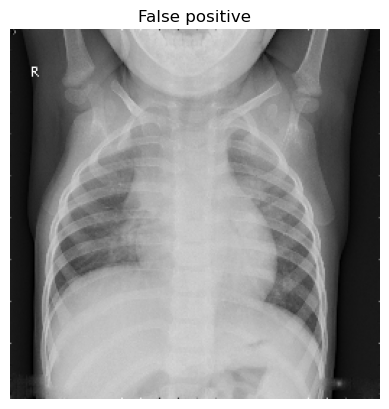

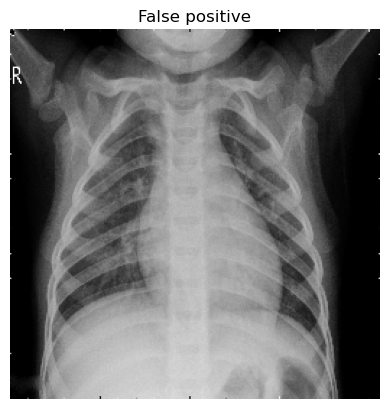

In [9]:
#show some of the models errors durring validation
mistake_images = val_im[wrong_indices.astype(bool)]
for img in mistake_images:
    plt.imshow(img, cmap="gray")
    plt.title("False positive")
    plt.axis("off")
    plt.show()

For reference, here they are in the context of all validation images:

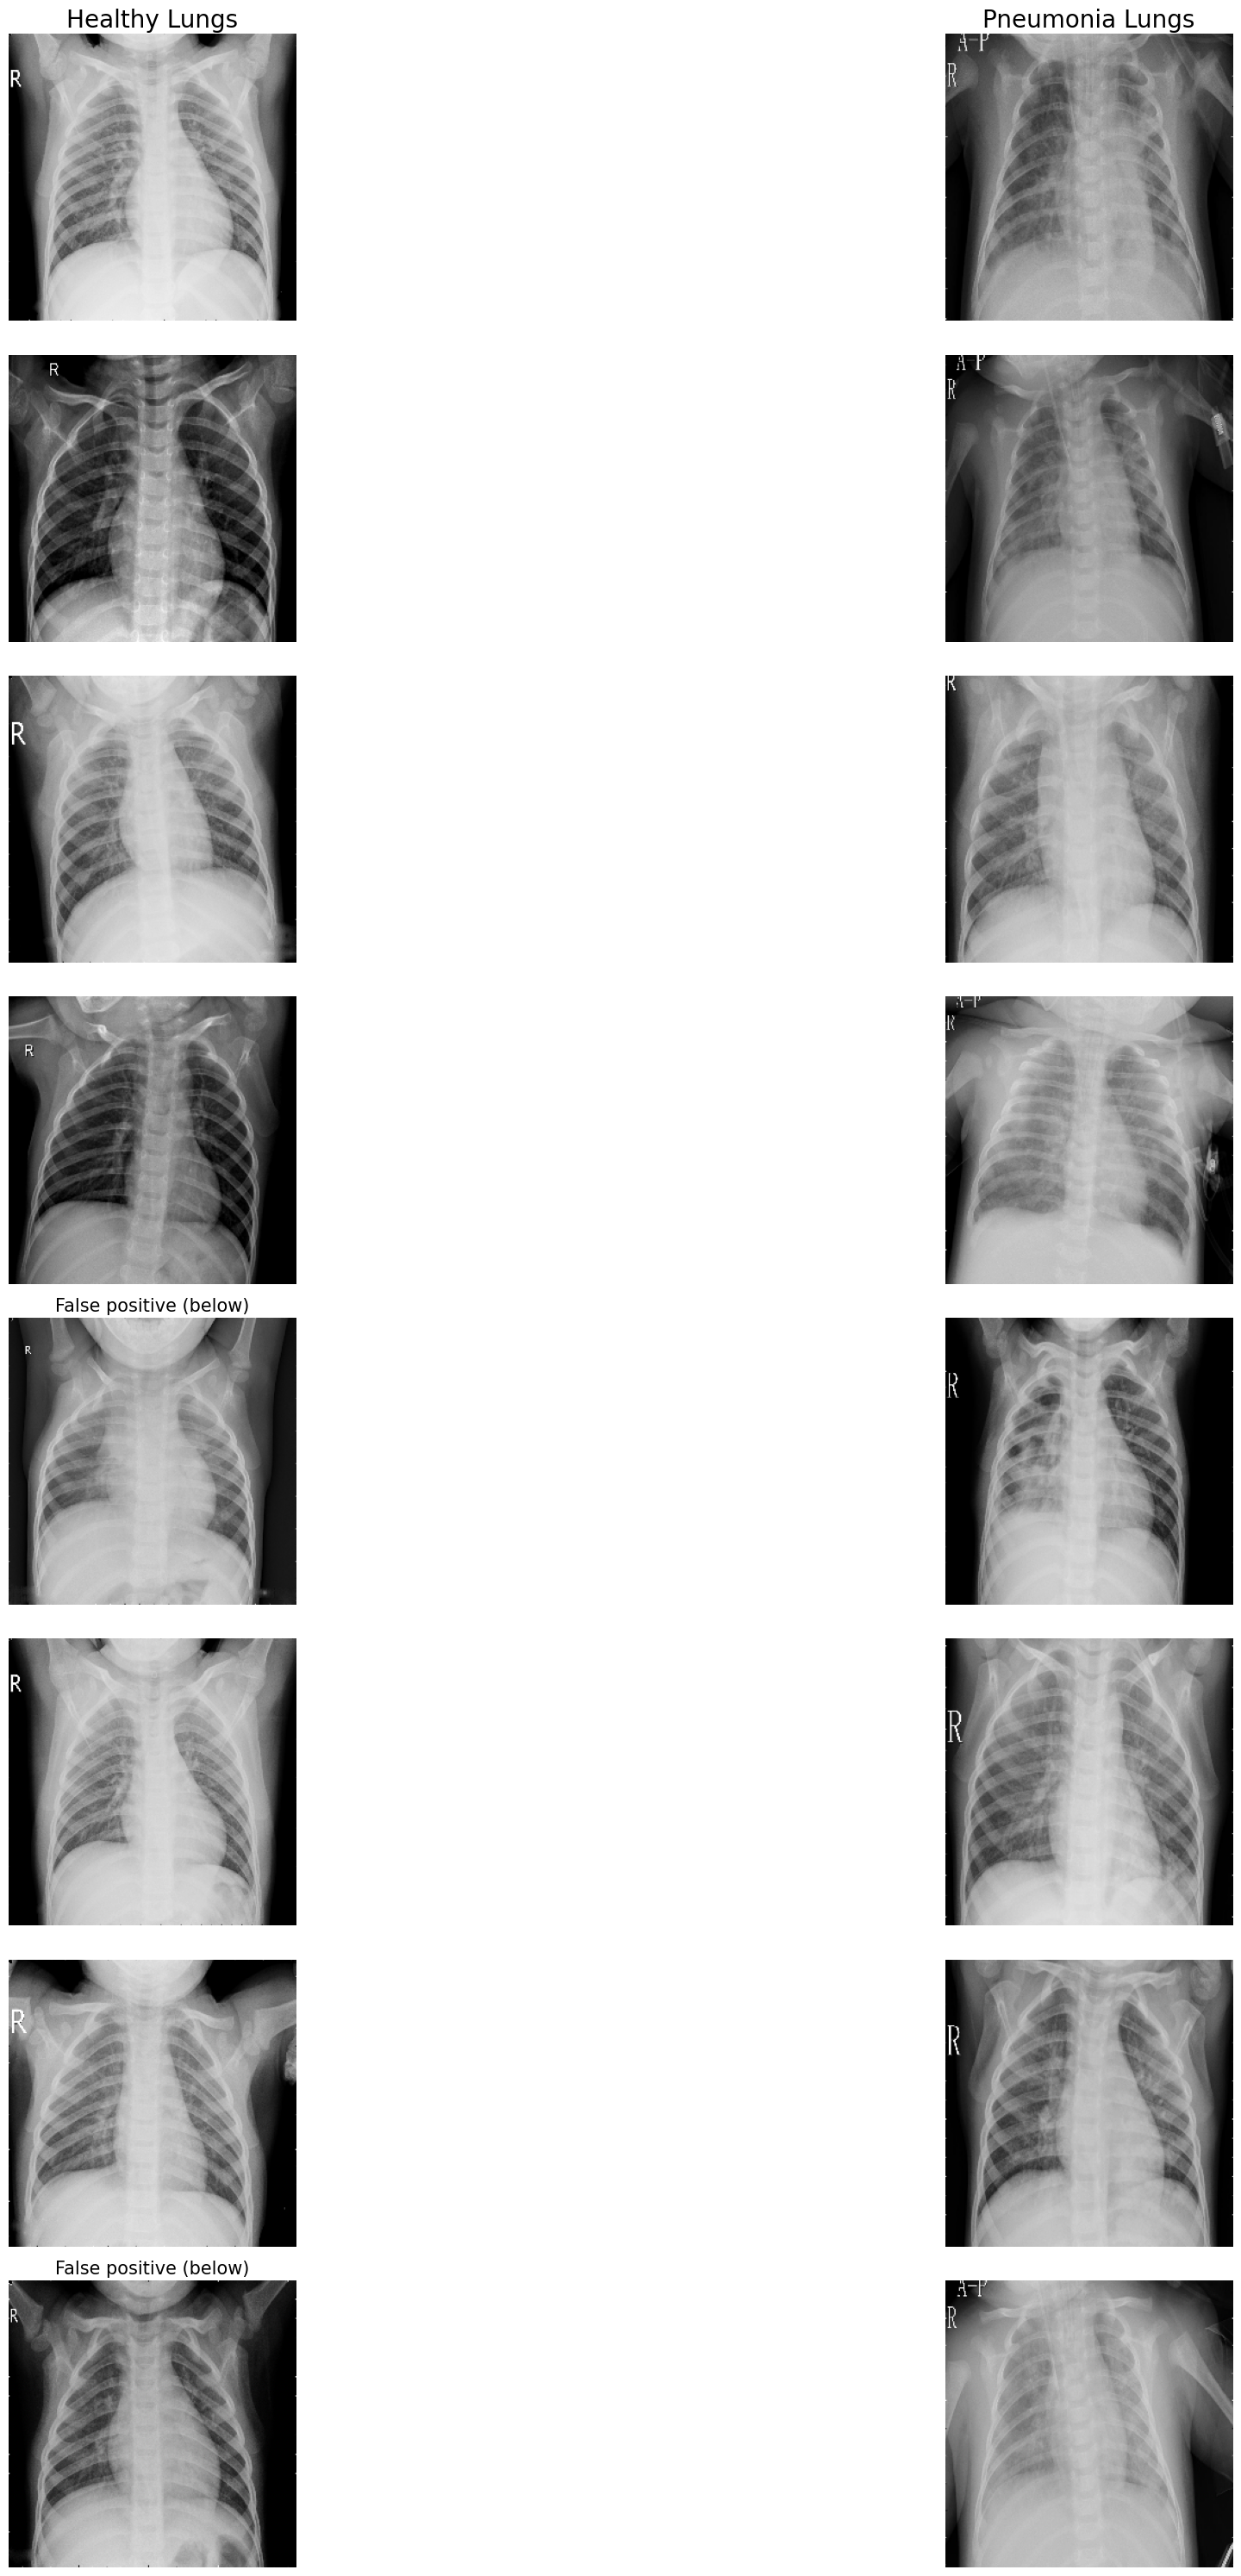

In [10]:
fig, axs = plt.subplots(8, 2, figsize = (30, 30), dpi=100,  squeeze=True)
normal_plotted = 0
pneum_plotted = 0
for img_index in range(len(val_label)):
    if val_label[img_index] == 1:
        axs[pneum_plotted][1].imshow(val_im[img_index], aspect="equal", cmap = "gray")
        axs[pneum_plotted][1].axis("off")
        pneum_plotted += 1
    else:
        axs[normal_plotted][0].imshow(val_im[img_index], aspect="equal", cmap = "gray")
        axs[normal_plotted][0].axis("off")
        if wrong_indices[img_index] == 1:
            axs[normal_plotted][0].set_title("False positive (below)", fontsize=15)
        normal_plotted += 1
axs[0][0].set_title("Healthy Lungs", fontsize=20)
axs[0][1].set_title("Pneumonia Lungs", fontsize=20)

plt.tight_layout()
plt.savefig(results_path + "/figures/false_positive_comparison.png")
plt.show()



In context, it's hard to see any difference between the false positives and the correctly predicted images. To the untrained eye, it is easy to see why the model erred. From studying the images we can identify the existance intermediate brightness, though it's hard to see any geometry differences between them and the others. Notably, the false positives may be a bit cloudier than the true positives, but this may or may not a reliable indicator of pneumonia (we don't know). Our best guess is that the model is picking up on some subtle difference in the cloudiness of the images, but it's hard to say for sure. Perhaps the two false positives are mild cases that are hard to detect even for a human. Regardless, the model is able to detect the majority of pneumonia cases with a high degree of accuracy, which is a good start. It is no secret that models like these will be used in conjunction with human doctors in the future so, while the accuracy is good, we hope to see continued accuracy improvements such that these models can be safely implemented and help to keep people healthy.